In [3]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
from scipy import stats

# Census API Key
from config import api_key
from us_state_abbrev import us_state_abbrev
c = Census(api_key, year=2013)

In [4]:
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E"), {'for': 'county:*'})
# CHECK FOR YEAR

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Name", "county": "County"})




In [5]:
census = census_pd[["County", "Name", "Population", "Median Age", "Household Income", ]].copy()
census

,County,Name,Population,Median Age,Household Income
0,033,"Escambia County, Florida",300795.0,37.4,43918.0
1,053,"Hernando County, Florida",173119.0,48.0,41024.0
2,057,"Hillsborough County, Florida",1257913.0,36.3,49596.0
3,091,"Okaloosa County, Florida",185852.0,37.4,54684.0
4,123,"Taylor County, Florida",22660.0,41.4,36356.0
...,...,...,...,...,...
3216,059,"Hancock County, Indiana",70466.0,39.4,62981.0
3217,067,"Howard County, Indiana",82795.0,41.0,43590.0
3218,017,"Oxford County, Maine",57657.0,45.0,40674.0
3219,001,"Allegany County, Maryland",74394.0,41.2,39293.0


In [6]:
# Final DataFrame
census = census_pd[["County", "Name", "Population", "Median Age", "Household Income"]].copy()
census.to_csv("resources/census_data.csv", encoding="utf-8", index=False)
census['county'] = census['Name'].str.replace(' County', '').str.replace(' Parish', '')
census.drop(['County', 'Name'], axis=1, inplace=True)
census.head()


,Population,Median Age,Household Income,county
0,300795.0,37.4,43918.0,"Escambia, Florida"
1,173119.0,48.0,41024.0,"Hernando, Florida"
2,1257913.0,36.3,49596.0,"Hillsborough, Florida"
3,185852.0,37.4,54684.0,"Okaloosa, Florida"
4,22660.0,41.4,36356.0,"Taylor, Florida"


In [9]:
covid = pd.read_csv('resources/covid-statistics.csv')
covid['county'] = covid['county'] + ', ' + covid['state']
covid.drop('state', axis=1, inplace=True)
covid

,date,county,fips,cases,deaths
0,2020-01-21,"Snohomish, Washington",53061.0,1,0.0
1,2020-01-22,"Snohomish, Washington",53061.0,1,0.0
2,2020-01-23,"Snohomish, Washington",53061.0,1,0.0
3,2020-01-24,"Cook, Illinois",17031.0,1,0.0
4,2020-01-24,"Snohomish, Washington",53061.0,1,0.0
...,...,...,...,...,...
2161172,2022-01-28,"Sweetwater, Wyoming",56037.0,10133,115.0
2161173,2022-01-28,"Teton, Wyoming",56039.0,9272,15.0
2161174,2022-01-28,"Uinta, Wyoming",56041.0,5273,34.0
2161175,2022-01-28,"Washakie, Wyoming",56043.0,2150,41.0


In [10]:
covid_total = covid.groupby('county').max()
covid_total.sort_values('county')

,date,fips,cases,deaths
county,,,,
"Abbeville, South Carolina",2022-01-28,45001.0,6104,57.0
"Acadia, Louisiana",2022-01-28,22001.0,14951,269.0
"Accomack, Virginia",2022-01-28,51001.0,6569,90.0
"Ada, Idaho",2022-01-28,16001.0,103141,915.0
"Adair, Iowa",2022-01-28,19001.0,1488,46.0
...,...,...,...,...
"Yuma, Arizona",2022-01-28,4027.0,57792,1046.0
"Yuma, Colorado",2022-01-28,8125.0,1703,22.0
"Zapata, Texas",2022-01-28,48505.0,2889,47.0


In [11]:
def makehealthcsv(x, colname):
        x = x[x["LocationAbbr"].isin(us_state_abbrev)]
        x = x[(x['Stratification1'] == 'Overall') &  (x['Stratification2'] == 'Overall')]
        x['county'] = x['LocationDesc'] + ', ' + x['LocationAbbr'].apply(lambda x: us_state_abbrev[x]) 
        x = x[['county','Data_Value']].dropna()
        x['county'] = x['county'].str.replace(' County', '').str.replace(' Parish', '')
        x.rename(columns = {'Data_Value' : colname}, inplace = True)
        x.drop_duplicates('county')
        return x

In [15]:
heart_disease = makehealthcsv(pd.read_csv("resources/Heart-Disease-by-County.csv"), 'Heart Disease')
heart_disease

,county,Heart Disease
0,"Aleutians East, Alaska",155.2
1,"Aleutians West, Alaska",174.2
2,"Anchorage, Alaska",249.3
3,"Bethel, Alaska",349.8
5,"Denali, Alaska",319.2
...,...,...
58681,"Teton, Wyoming",170.5
58682,"Uinta, Wyoming",353.4
58683,"Washakie, Wyoming",314.5
58684,"Weston, Wyoming",290.6


In [17]:
stroke = makehealthcsv(pd.read_csv("resources/Stroke-by-County.csv"), 'Stroke')
stroke

,county,Stroke
0,"Aleutians East, Alaska",2.0
1,"Aleutians West, Alaska",0.0
2,"Anchorage, Alaska",63.7
3,"Bethel, Alaska",105.5
5,"Denali, Alaska",58.0
...,...,...
58681,"Teton, Wyoming",48.2
58682,"Uinta, Wyoming",52.8
58683,"Washakie, Wyoming",66.3
58684,"Weston, Wyoming",60.0


In [18]:
merged_df = pd.merge(covid_total, census, on='county')
merged_df = pd.merge(merged_df, heart_disease, on='county')
merged_df = pd.merge(merged_df, stroke, on='county')
merged_df.sort_values('county')
merged_df.dropna()
merged_df[['County','State']] = merged_df.county.str.split(", ",expand=True)
merged_df.drop(columns = ['fips', 'county', 'date'], inplace = True)
merged_df.rename(columns = {'cases' : 'Cases', 'deaths' : 'Deaths'}, inplace=True)
merged_df['Cases per Capita'] = merged_df['Cases']/merged_df['Population']
merged_df['Deaths per Capita'] = merged_df['Deaths']/merged_df['Population']
merged_df.sort_values('Cases per Capita', ascending = False)
merged_df.drop(merged_df.loc[merged_df['Population'] < 20000].index, inplace = True)
merged_df.drop(merged_df.loc[merged_df['Population'] > 200000].index, inplace = True)
merged_df.to_csv('data.csv')
merged_df.head()

,Cases,Deaths,Population,Median Age,Household Income,Heart Disease,Stroke,County,State,Cases per Capita,Deaths per Capita
0,6104,57.0,25233.0,42.8,35947.0,321.0,78.6,Abbeville,South Carolina,0.241905,0.002259
1,14951,269.0,61847.0,35.5,37587.0,476.2,93.6,Acadia,Louisiana,0.241742,0.004349
2,6569,90.0,33289.0,44.8,39328.0,411.2,92.1,Accomack,Virginia,0.197332,0.002704
6,5535,56.0,25573.0,29.0,34733.0,335.1,80.7,Adair,Missouri,0.216439,0.002190
7,6678,65.0,22427.0,36.7,32556.0,575.0,62.7,Adair,Oklahoma,0.297766,0.002898


In [19]:
corr = merged_df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Cases,Deaths,Population,Median Age,Household Income,Heart Disease,Stroke,Cases per Capita,Deaths per Capita
Cases,1.000000,0.827684,0.945662,-0.269686,0.292797,-0.168769,-0.060318,0.327555,-0.087194
Deaths,0.827684,1.000000,0.807026,-0.112701,0.057191,0.054559,0.084010,0.217806,0.324927
Population,0.945662,0.807026,1.000000,-0.195069,0.334513,-0.205112,-0.098775,0.067935,-0.178971
Median Age,-0.269686,-0.112701,-0.195069,1.000000,-0.033167,-0.043632,-0.098485,-0.334543,0.084126
Household Income,0.292797,0.057191,0.334513,-0.033167,1.000000,-0.500777,-0.412462,-0.025004,-0.474391
Heart Disease,-0.168769,0.054559,-0.205112,-0.043632,-0.500777,1.000000,0.520112,0.105578,0.520469
Stroke,-0.060318,0.084010,-0.098775,-0.098485,-0.412462,0.520112,1.000000,0.099011,0.388930
Cases per Capita,0.327555,0.217806,0.067935,-0.334543,-0.025004,0.105578,0.099011,1.000000,0.293791
Deaths per Capita,-0.087194,0.324927,-0.178971,0.084126,-0.474391,0.520469,0.388930,0.293791,1.000000


In [20]:
#Takes axis and col names, r=True puts r-value in legend, by default it doesn't, xunit/yunit add unit to labels
def makescatter(ax, col1, col2, r=False, xunit='', yunit=''):
    xs = merged_df[col1]
    ys = merged_df[col2]
    (m, b, rvalue, _, _) = stats.linregress(xs, ys)
    regress = [m*x + b for x in xs]
    ax.scatter(xs, ys)
    ax.plot(xs, regress, 'r-', label=round(rvalue**2, 3))
    if xunit:
        col1 += f' ({xunit})'
    if yunit:
        col2 += f' ({yunit})'
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_title(col1 + ' vs ' + col2)
    if r:
        ax.legend()
    return

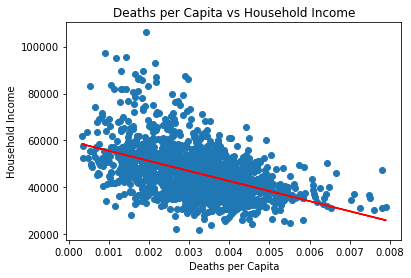

In [21]:
#plotting 1 plot, no extra stuff
fig, ax1 = plt.subplots(1,1)

makescatter(ax1, 'Deaths per Capita', 'Household Income')


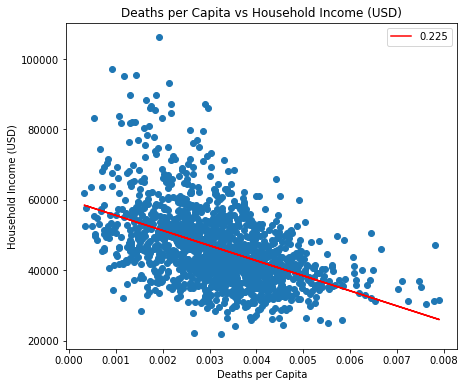

In [22]:
#plotting 1 plot, with rvalue and yunit and figsize corrected
fig, ax1 = plt.subplots(1,1, figsize=(7,6))

makescatter(ax1, 'Deaths per Capita', 'Household Income', r=True, yunit='USD')


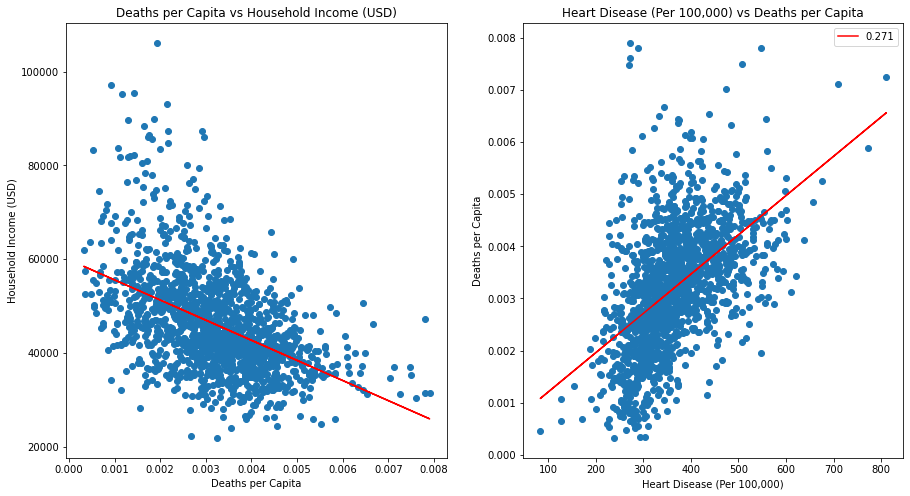

In [23]:
#plotting 2 plots

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

makescatter(ax1, 'Deaths per Capita', 'Household Income', yunit='USD')

makescatter(ax2, 'Heart Disease', 'Deaths per Capita', xunit='Per 100,000', r=True)
